In [1]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"



!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
import torch
from matplotlib import animation

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle("Policy", size=18)
    plt.tight_layout()


def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(state_values, annot=True, fmt=".2f", cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def test_agent(env, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)


def plot_action_values(action_values):

    text_positions = [
        [(0.35, 4.75), (1.35, 4.75), (2.35, 4.75), (3.35, 4.75), (4.35, 4.75),
         (0.35, 3.75), (1.35, 3.75), (2.35, 3.75), (3.35, 3.75), (4.35, 3.75),
         (0.35, 2.75), (1.35, 2.75), (2.35, 2.75), (3.35, 2.75), (4.35, 2.75),
         (0.35, 1.75), (1.35, 1.75), (2.35, 1.75), (3.35, 1.75), (4.35, 1.75),
         (0.35, 0.75), (1.35, 0.75), (2.35, 0.75), (3.35, 0.75), (4.35, 0.75)],
        [(0.6, 4.45), (1.6, 4.45), (2.6, 4.45), (3.6, 4.45), (4.6, 4.45),
         (0.6, 3.45), (1.6, 3.45), (2.6, 3.45), (3.6, 3.45), (4.6, 3.45),
         (0.6, 2.45), (1.6, 2.45), (2.6, 2.45), (3.6, 2.45), (4.6, 2.45),
         (0.6, 1.45), (1.6, 1.45), (2.6, 1.45), (3.6, 1.45), (4.6, 1.45),
         (0.6, 0.45), (1.6, 0.45), (2.6, 0.45), (3.6, 0.45), (4.6, 0.45)],
        [(0.35, 4.15), (1.35, 4.15), (2.35, 4.15), (3.35, 4.15), (4.35, 4.15),
         (0.35, 3.15), (1.35, 3.15), (2.35, 3.15), (3.35, 3.15), (4.35, 3.15),
         (0.35, 2.15), (1.35, 2.15), (2.35, 2.15), (3.35, 2.15), (4.35, 2.15),
         (0.35, 1.15), (1.35, 1.15), (2.35, 1.15), (3.35, 1.15), (4.35, 1.15),
         (0.35, 0.15), (1.35, 0.15), (2.35, 0.15), (3.35, 0.15), (4.35, 0.15)],
        [(0.05, 4.45), (1.05, 4.45), (2.05, 4.45), (3.05, 4.45), (4.05, 4.45),
         (0.05, 3.45), (1.05, 3.45), (2.05, 3.45), (3.05, 3.45), (4.05, 3.45),
         (0.05, 2.45), (1.05, 2.45), (2.05, 2.45), (3.05, 2.45), (4.05, 2.45),
         (0.05, 1.45), (1.05, 1.45), (2.05, 1.45), (3.05, 1.45), (4.05, 1.45),
         (0.05, 0.45), (1.05, 0.45), (2.05, 0.45), (3.05, 0.45), (4.05, 0.45)]]

    fig, ax = plt.subplots(figsize=(7, 7))
    tripcolor = quatromatrix(action_values, ax=ax,
                             triplotkw={"color": "k", "lw": 1}, tripcolorkw={"cmap": "coolwarm"})
    ax.margins(0)
    ax.set_aspect("equal")
    fig.colorbar(tripcolor)

    for j, av in enumerate(text_positions):
        for i, (xi, yi) in enumerate(av):
            plt.text(xi, yi, round(action_values[:, :, j].flatten()[i], 2), size=8, color="w", weight="bold")

    plt.title("Action values Q(s,a)", size=18)
    plt.tight_layout()
    plt.show()


def quatromatrix(action_values, ax=None, triplotkw=None, tripcolorkw=None):
    action_values = np.flipud(action_values)
    n = 5
    m = 5
    a = np.array([[0, 0], [0, 1], [.5, .5], [1, 0], [1, 1]])
    tr = np.array([[0, 1, 2], [0, 2, 3], [2, 3, 4], [1, 2, 4]])
    A = np.zeros((n * m * 5, 2))
    Tr = np.zeros((n * m * 4, 3))
    for i in range(n):
        for j in range(m):
            k = i * m + j
            A[k * 5:(k + 1) * 5, :] = np.c_[a[:, 0] + j, a[:, 1] + i]
            Tr[k * 4:(k + 1) * 4, :] = tr + k * 5
    C = np.c_[action_values[:, :, 3].flatten(), action_values[:, :, 2].flatten(),
              action_values[:, :, 1].flatten(), action_values[:, :, 0].flatten()].flatten()

    ax.triplot(A[:, 0], A[:, 1], Tr, **triplotkw)
    tripcolor = ax.tripcolor(A[:, 0], A[:, 1], Tr, facecolors=C, **tripcolorkw)
    return tripcolor


def seed_everything(env: gym.Env, seed: int = 42) -> None:
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)


def plot_tabular_cost_to_go(action_values, xlabel, ylabel):
    plt.figure(figsize=(8, 8))
    cost_to_go = -action_values.max(axis=-1)
    plt.imshow(cost_to_go, cmap='jet')
    plt.title("Estimated cost-to-go", size=24)
    plt.xlabel(xlabel, size=18)
    plt.ylabel(ylabel, size=18)
    plt.xticks([])
    plt.yticks([])
    plt.xticks()
    plt.colorbar()
    plt.tight_layout()
    plt.show()


def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
env = gym.make('MountainCar-v0')
seed_everything(env)

## Create the Tile Coding Wrapper


In [43]:
class TIleCodingEnv(gym.ObservationWrapper):

  def __init__(self, env, bins, low, high, n):
    super().__init__(env)
    self.tilings =self._create_tilings(bins, high, low, n)

    # State Aggregation同様に[20 , 20] -> 400の空間を持つStateを作成したうえで
    # TileCoding独自の複数Stateを作るためnをかけている
    self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist() *n)

  def observation(self, state):
    # gymから返ってくる連続値のStateをAggregattionなState(400)に変換する
    # ただし今回はtileのため返すbinはlistになる
    # [-1.2, 0.] -> [(4, 3), (5,3), (5,2), (5,2)]
    indices = []

    # np.digitizeは第一引数の値[list[int]]それぞれが第二引数のbinの境界の何番目に当たるかを調べる
    for t in self.tilings:
      tiling_indices = tuple(np.digitize(i, b) for i, b in zip(state, t))
      indices.append(tiling_indices)

    return indices

  def _create_tilings(self, bins, high, low, n):
    # 1から始まる奇数の配列. tileのオフセット計算に利用
    # [1, 3]
    displacement_vector = np.arange(1, 2 * len(bins), 2)
    tilings = []

    # tileをn個作成
    for i in range(1, n+1):
      # 元の各Actionの最大、最小から一定の割合を引く
      # tileのランダム性を担保するため
      low_i = low - random.random() * 0.2 * low
      #   ここの+ を - に書き間違えていたので学習が上手くいかなかった
      high_i = high + random.random() * 0.2 * high

      # segment_size = tileの幅
      # high - low で各Actionの幅がわかる
      # これをbinで割ることによりタイルの各セグメントの大きさを測っている
      segment_sizes = (high_i - low_i) / bins

      # tileのオフセットを計算
      # i をかけることににより各タイルごとに異なるオフセットを利用
      displacements = displacement_vector * i % n

      # オフセットの基準値に実際のセグメントの大きさをかけて、セグメントのサイズにスケーリングさせる
      displacements = displacements * (segment_sizes / n)
      low_i += displacements
      high_i += displacements

      buckets_i = [np.linspace(l, h, b-1) for l, h, b in zip(low_i, high_i, bins)]
      tilings.append(buckets_i)

    return tilings



In [44]:
tilings=4
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high
tcenv = TIleCodingEnv(env, bins, low, high, tilings)
print(f"{bins=} {low=} {high=}")

bins=array([20, 20]) low=array([-1.2 , -0.07], dtype=float32) high=array([0.6 , 0.07], dtype=float32)


In [13]:
print(f"Modified observation space: {tcenv.observation_space}, \n\
Sample state: {tcenv.reset()}")
# tile 分Stateが出力されている

Modified observation space: MultiDiscrete([20 20 20 20 20 20 20 20]), 
Sample state: [(0, 0), (0, 0), (0, 0), (0, 1)]


In [10]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.reset()}")

Original observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Sample state: [-0.5122243  0.       ]


In [15]:
# tile -> 4
# State -> 20 x 20
# actionは 左、なにもしない、右の３種類
action_values = np.zeros((4, 20, 20, 3))

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [16]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av_list = []
        # 今回StateはTileのため４つある
        # [(0, 0), (0, 0), (0, 0), (0, 1)]
        for i, idx in enumerate(state):
            av = action_values[i][idx]
            av_list.append(av)

        # tile codingnなのでそれぞれのQ-tableの平均を取る
        # 　Q table は 3つActionがあるので、Tile事にそれぞれ値が取れている
        #   e.g [[1,2,3], [3, 2, 1]....]
        #  axis = 0で平均を取って [1.5, 2.5, 3.5]のようにする
        av = np.mean(av_list, axis=0)
        return np.random.choice(np.flatnonzero(av==av.max()))

### Test the SARSA algorithm on the modified environment



In [42]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = tcenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = tcenv.step(action)
            next_action = policy(next_state, epsilon)

            for i, (idx, next_idx) in enumerate(zip(state, next_state)):
                qsa = action_values[i][idx][action]
                next_qsa = action_values[i][next_idx][next_action]
                action_values[i][idx][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)

            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [47]:
stats = sarsa(action_values, policy, 10000, alpha=0.1, epsilon=0.)

100%|██████████| 10000/10000 [06:04<00:00, 27.46it/s]


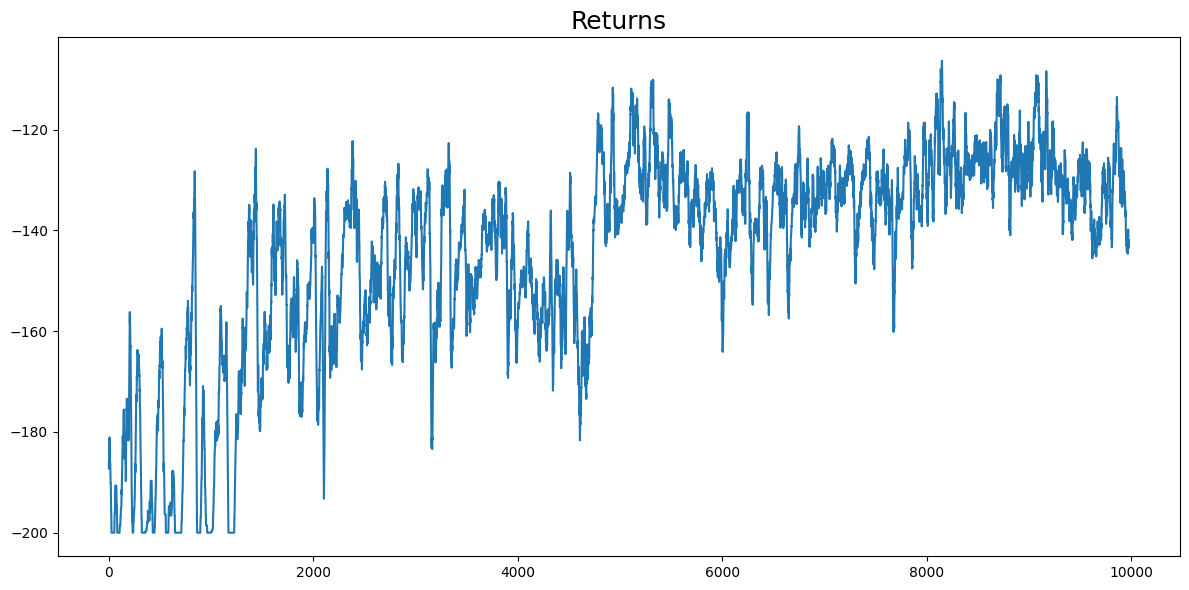

In [48]:
plot_stats(stats)

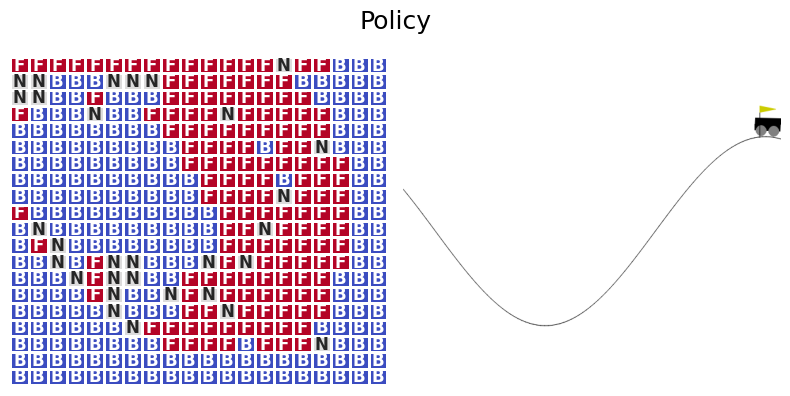

In [49]:
plot_policy(action_values.mean(axis=0), env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

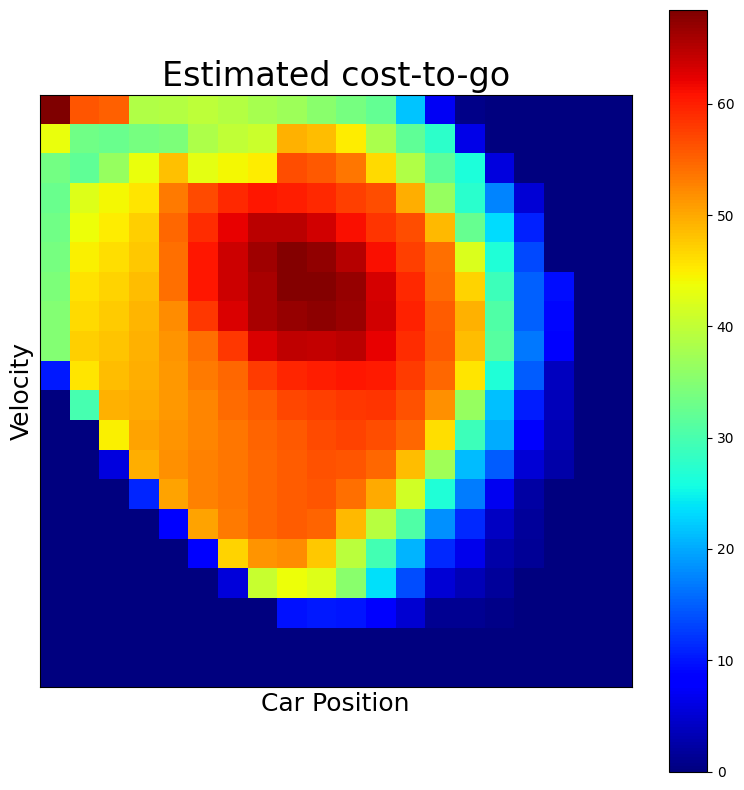

In [50]:
plot_tabular_cost_to_go(action_values.mean(axis=0), \
                        xlabel="Car Position", ylabel="Velocity")
# state aggregationと違って滑らかになっている

In [51]:
test_agent(tcenv, policy, 2)